In [1]:
from fastai.vision.all import *
from fastbook import *
import pixiedust

Pixiedust database opened successfully


In [2]:
path = untar_data(URLs.MNIST_SAMPLE)


In [3]:
path.ls()

(#3) [Path('/home/jupyter/.fastai/data/mnist_sample/valid'),Path('/home/jupyter/.fastai/data/mnist_sample/train'),Path('/home/jupyter/.fastai/data/mnist_sample/labels.csv')]

In [4]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [5]:
tensor_3 = [tensor(Image.open(i)) for i in threes]
tensor_7 = [tensor(Image.open(i)) for i in sevens]

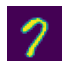

In [6]:
img = tensor_7[3]
show_image(img)

In [7]:
stacked_3 = torch.stack(tensor_3).float()/255
stacked_7 = torch.stack(tensor_7).float()/255

In [8]:
stacked_3.shape, stacked_7.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

In [9]:
train_x = torch.cat([stacked_3, stacked_7]).view(-1, 28 * 28)

In [10]:
train_x.shape

torch.Size([12396, 784])

In [11]:
train_y = (tensor([1] * len(threes) + [0] * len(sevens))).unsqueeze(1)

In [12]:
train_y.shape

torch.Size([12396, 1])

In [13]:
valid_3 = [tensor(Image.open(i)) for i in (path/'valid'/'3').ls()]
valid_7 = [tensor(Image.open(i)) for i in (path/'valid'/'7').ls()]

In [14]:
stacked_3_valid = torch.stack(valid_3).float()/255
stacked_7_valid = torch.stack(valid_7).float()/255

In [15]:
valid_x = torch.cat([stacked_3_valid, stacked_7_valid]).view(-1, 28 * 28)
valid_x.shape

torch.Size([2038, 784])

In [16]:
valid_y = (tensor([1] * len(valid_3) + [0] * len(valid_7))).unsqueeze(1)
valid_y.shape

torch.Size([2038, 1])

# Build DataLoaders for both Training and Valid

In [17]:
ds = list(zip(train_x, train_y))

dl = DataLoader(ds, shuffle=True, batch_size=256)


In [18]:
ds_val = list(zip(valid_x, valid_y))

dl_valid = DataLoader(ds_val, shuffle=True, batch_size=256)

In [48]:
x, y = first(dl_valid)


In [49]:
x.shape, y.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [27]:
class BasicOptimizer:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr
        
    def step(self, *args, **kwards):
        for p in self.params:
            p.data -= self.lr * p.grad
    
    def zero_grad(self, *args, **kwargs):
        for p in params:
            p.grad.zero_()

In [28]:
dls = DataLoaders(dl, dl_valid)

In [67]:
class Learner_try:
    def __init__(self, dl, model, opt):
        self.dl_train = dl[0]
        self.dl_valid = dl[1]
        self.model = model
        self.opt = opt(self.model.parameters(), lr = 0.1)
        
    
    def mnist_loss(self, preds, targets):
        preds = preds.sigmoid()
        return torch.where(targets==1, 1 - preds, preds).mean()
    
    def batch_accuracy(self, x, y):
        preds = x.sigmoid()
        correct = (preds>0.5) == y
        return correct.float().mean()
    
    def validate_epoch(self):
        accs = [self.batch_accuracy(self.model(x), y) for x,y in self.dl_valid]
        return round(torch.stack(accs).mean().item(), 4)
    
    def cal_grad(self, x, y):
        preds = self.model(x)
        loss = self.mnist_loss(preds, y)
        loss.backward()
    
    def train_epoch(self):
        for x, y in self.dl_train:
            self.cal_grad(x, y)
            self.opt.step()
            #self.opt.zero_grad()      
            
    def fit(self, epochs):
        for i in range(epochs):
            self.train_epoch()
            print(self.validate_epoch(), end = " ")
        

In [68]:
simple_net = nn.Sequential(nn.Linear(28 * 28, 30),
                          nn.ReLU(),
                          nn.Linear(30, 1),
                          nn.Sigmoid())

opt = SGD

learn = Learner_try(dls, simple_net, opt = opt)

learn.fit(20)

In [51]:
doc(SGD)

# Building a model for a complete Dataset - MNIST

In [73]:
path = untar_data(URLs.MNIST)

In [74]:
path.ls()

(#2) [Path('/home/jupyter/.fastai/data/mnist_png/training'),Path('/home/jupyter/.fastai/data/mnist_png/testing')]

In [75]:
data = ImageDataLoaders.from_folder(path = path, train = 'training', valid = 'testing', shuffle_train = True)

In [77]:
len(data.train)

937

In [78]:
class Learner_full:
    def __init__(self, dls, model, opt, loss):
        self.dl_train = dls.train
        self.dl_valid = dls.valid
        self.model = model
        self.opt = opt(self.model.parameters, lr = 0.1)
        self.loss = loss
        
    def batch_accuracy(self, x, y):
        probs = torch.softmax(preds, dim=1)
        winners = probs.argmax(dim=1)
        corrects = (winners == yb)
        accuracy = corrects.sum().float() / float( yb.size(0) )
        return accuracy
    
    def validate_epoch(self):
        accs = [self.batch_accuracy(self.model(x), y) for x,y in self.dl_valid]
        return round(torch.stack(accs).mean().item(), 4)
    
    def cal_grad(self, x, y):
        preds = self.model(x)
        loss = self.loss(preds, y)
        loss.backward()
    
    def train_epoch(self):
        for x, y in self.dl_train:
            self.cal_grad(x, y)
            self.opt.step()
            #self.opt.zero_grad()      
            
    def fit(self, epochs):
        for i in range(epochs):
            self.train_epoch()
            print(self.validate_epoch(), end = " ")
        

In [80]:
simple_net = nn.Sequential(
    Flatten(),
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30, 10)
)

In [81]:
mnist_learner = Learner(dls, simple_net, SGD, nn.CrossEntropyLoss())
mnist_learner.fit(10)

TypeError: forward() got an unexpected keyword argument 'lr'

In [82]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(train_name='training', valid_name='testing'),
                  get_y=parent_label)

In [83]:
dls = mnist.dataloaders(path, num_workers = 0)

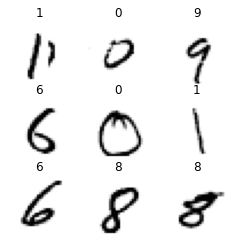

In [84]:
dls.show_batch(max_n=9, figsize=(4,4))

In [85]:
simple_net = nn.Sequential(
    Flatten(),
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30, 10)
)

In [87]:
class Learner():
    
    def __init__(self, dataloaders, model, opt, loss):
        
        self.train_dl = dataloaders[0]
        self.valid_dl = dataloaders[1]
        self.model = model
        self.opt = opt(self.model.parameters(), lr=0.1)
        self.loss = loss
        
    def train_epoch(self):
                
        for xb,yb in self.train_dl:
            preds = self.model(xb)
            calculated_loss = self.loss(preds, yb.long())
            calculated_loss.backward()
            self.opt.step()
            self.opt.zero_grad()
            
            
    def batch_accuracy(self, preds, yb):
        
        probs = torch.softmax(preds, dim=1)
        winners = probs.argmax(dim=1)
        corrects = (winners == yb)
        accuracy = corrects.sum().float() / float( yb.size(0) )
        return accuracy

        
    def validate_epoch(self):
        
        accs = [self.batch_accuracy(self.model(xb), yb) for xb,yb in self.valid_dl]
        return round(torch.stack(accs).mean().item(), 4)
                            
    def fit(self, n):
        
        for epoch in range(n):
            self.train_epoch()
            print(self.validate_epoch(), end=' ')

In [89]:
mnist_learner = Learner(dls, simple_net, SGD, nn.CrossEntropyLoss())
mnist_learner.fit(10)

KeyboardInterrupt: 